In [27]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypsa.linopf import *
from pypsa.linopt import *

from pyomo.environ import Constraint

network = pypsa.Network()

network.snapshots = pd.date_range("2020-01-01 00:00", "2020-03-30 23:00", freq="H")

network.snapshots

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-03-30 14:00:00', '2020-03-30 15:00:00',
               '2020-03-30 16:00:00', '2020-03-30 17:00:00',
               '2020-03-30 18:00:00', '2020-03-30 19:00:00',
               '2020-03-30 20:00:00', '2020-03-30 21:00:00',
               '2020-03-30 22:00:00', '2020-03-30 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2160, freq='H')

In [28]:
def extra_functionality(network, snapshots):
    model = network.model
    model.link_fix = Constraint(
        rule=lambda model: model.link_p_nom["Link2Store"]
        == model.link_p_nom["Link2Main"]* network.links.loc['Link2Main','efficiency'])

In [29]:
network.add("Bus", "Main", v_nom=380)
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
Main,380.0,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,


In [30]:
network.add(
    "Load", 
    name="TotalLoads", 
    bus="Main", 
    p_set=23000)
    # p_set=[25200,25200,25200,25200,25200,25200,25200,25200,25200,25200,])

In [31]:
network.add(
    "Generator", 
    name="TotalGenerators", 
    bus="Main", 
    p_nom=32500,
    #p_max_pu=[1,0.978593,0.948012,0.88685,0.8104,0.7034,0.6422,0.62691,0.61468,0.60856],
    p_max_pu=(6250*np.cos(np.linspace(0,9,num=720*3)*(np.pi/9))+26250)/32500,
    capital_cost=1.04*10**6,
    efficiency=1,
    marginal_cost=2.3,
    carrier="AC")

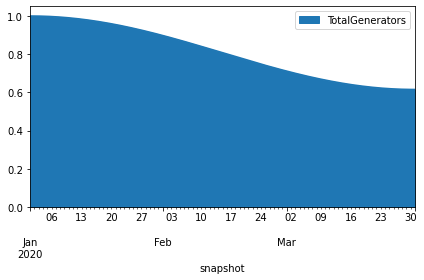

In [32]:
network.generators_t.p_max_pu.plot.area(subplots=True)
plt.tight_layout()

In [33]:
network.add("Bus", "StoreIsland", carrier="AC")
#parameterBank parameters = [Link 1 capital_cost, Link 1 efficiency, Link 2 capital_cost, Link 2 efficiency, Store capital costs]
parameterBank = [[0.2055  , 0.9     , 0.2055  , 0.9     , 0.192   ], #Lithium
       [0.35    , 0.8     , 0.35    , 0.58    , 0.01064 ], #H2
       [0.462238, 0.7211  , 0.633112, 0.7211  , 0.003477], #CAES
       [0.367   , 0.7746  , 0.367   , 0.7746  , 0.09437 ], #LAES
       [0.17766 , 0.6708  , 0.17766 , 0.6708  , 0.08883 ], #ETES
       [0.176515, 0.866   , 0.176515, 0.866   , 0.62289 ], #NaS
       [0.75    , 0.8944  , 0.75    , 0.8944  , 0.125   ]] #Fe-Flow
storeSeriesData = pd.DataFrame()
storeObjectives = [0 for a in range(7)]
storeCapacities = [0 for a in range(7)]
#columnNames = ['LIB','H2']

In [34]:
for i in range(7):
    #LINKS
    #Charger Link
    network.add(
        "Link",
        name="Link2Store",
        bus0="Main",
        bus1="StoreIsland",
        capital_cost=parameterBank[i][0]*10**6,
        p_nom_extendable=True,
        #marginal_cost=0,
        efficiency=parameterBank[i][1],
    )

    #Discharger Link
    network.add(
        "Link",
        name="Link2Main",
        bus0="StoreIsland",
        bus1="Main",
        capital_cost=parameterBank[i][2]*10**6,
        p_nom_extendable=True,
        #marginal_cost=0.01,
        efficiency=parameterBank[i][3]
    )

    #STORE
    network.add(
        "Store",
        "TheStorage",
        bus="StoreIsland",
        capital_cost=parameterBank[i][4]*10**6,
        e_nom_extendable=True,
        e_cyclic=True
    )

    if i==0 or i==5 or i==6:
        network.lopf(extra_functionality=extra_functionality)
    else:
        network.lopf()

    print(network.links)
        
    storeSeriesData = storeSeriesData.append(network.stores_t.e)
    storeObjectives[i] = network.objective
    storeCapacities[i] = network.stores_t.e.max()

    network.mremove("Store",["TheStorage"])
    network.mremove("Link",["Link2Main","Link2Store"])
    


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 296526290235.332
  Upper bound: 296526290235.332
  Number of objectives: 1
  Number of constraints: 19442
  Number of variables: 10804
  Number of nonzeros: 38883
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 2.6498239040374756
# ----------------------------------------------------------
#   Solution Information
# ----

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_558/3625517449.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


attribute          bus0         bus1 type carrier  efficiency  build_year  \
Link                                                                        
Link2Store         Main  StoreIsland           AC         0.9           0   
Link2Main   StoreIsland         Main           AC         0.9           0   

attribute   lifetime  p_nom  p_nom_extendable  p_nom_min  ...  p_set  \
Link                                                      ...          
Link2Store       inf    0.0              True        0.0  ...    0.0   
Link2Main        inf    0.0              True        0.0  ...    0.0   

attribute   p_min_pu  p_max_pu  capital_cost  marginal_cost  length  \
Link                                                                  
Link2Store       0.0       1.0      205500.0            0.0     0.0   
Link2Main        0.0       1.0      205500.0            0.0     0.0   

attribute   terrain_factor  ramp_limit_up  ramp_limit_down    p_nom_opt  
Link                                       

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 28096033489.7965
  Upper bound: 28096033489.7965
  Number of objectives: 1
  Number of constraints: 19441
  Number of variables: 10804
  Number of nonzeros: 38881
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.4386494159698486
# ----------------------------------------------------------
#   Solution Information
# ----

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_558/3625517449.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


attribute          bus0         bus1 type carrier  efficiency  build_year  \
Link                                                                        
Link2Store         Main  StoreIsland           AC        0.80           0   
Link2Main   StoreIsland         Main           AC        0.58           0   

attribute   lifetime  p_nom  p_nom_extendable  p_nom_min  ...  p_set  \
Link                                                      ...          
Link2Store       inf    0.0              True        0.0  ...    0.0   
Link2Main        inf    0.0              True        0.0  ...    0.0   

attribute   p_min_pu  p_max_pu  capital_cost  marginal_cost  length  \
Link                                                                  
Link2Store       0.0       1.0      350000.0            0.0     0.0   
Link2Main        0.0       1.0      350000.0            0.0     0.0   

attribute   terrain_factor  ramp_limit_up  ramp_limit_down    p_nom_opt  
Link                                       

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 10342524801.0599
  Upper bound: 10342524801.0599
  Number of objectives: 1
  Number of constraints: 19441
  Number of variables: 10804
  Number of nonzeros: 38881
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.8839948177337646
# ----------------------------------------------------------
#   Solution Information
# ----

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_558/3625517449.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


attribute          bus0         bus1 type carrier  efficiency  build_year  \
Link                                                                        
Link2Store         Main  StoreIsland           AC      0.7211           0   
Link2Main   StoreIsland         Main           AC      0.7211           0   

attribute   lifetime  p_nom  p_nom_extendable  p_nom_min  ...  p_set  \
Link                                                      ...          
Link2Store       inf    0.0              True        0.0  ...    0.0   
Link2Main        inf    0.0              True        0.0  ...    0.0   

attribute   p_min_pu  p_max_pu  capital_cost  marginal_cost  length  \
Link                                                                  
Link2Store       0.0       1.0      462238.0            0.0     0.0   
Link2Main        0.0       1.0      633112.0            0.0     0.0   

attribute   terrain_factor  ramp_limit_up  ramp_limit_down    p_nom_opt  
Link                                       

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 170695402216.87
  Upper bound: 170695402216.87
  Number of objectives: 1
  Number of constraints: 19441
  Number of variables: 10804
  Number of nonzeros: 38881
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.150216817855835
# ----------------------------------------------------------
#   Solution Information
# -------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_558/3625517449.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


attribute          bus0         bus1 type carrier  efficiency  build_year  \
Link                                                                        
Link2Store         Main  StoreIsland           AC      0.7746           0   
Link2Main   StoreIsland         Main           AC      0.7746           0   

attribute   lifetime  p_nom  p_nom_extendable  p_nom_min  ...  p_set  \
Link                                                      ...          
Link2Store       inf    0.0              True        0.0  ...    0.0   
Link2Main        inf    0.0              True        0.0  ...    0.0   

attribute   p_min_pu  p_max_pu  capital_cost  marginal_cost  length  \
Link                                                                  
Link2Store       0.0       1.0      367000.0            0.0     0.0   
Link2Main        0.0       1.0      367000.0            0.0     0.0   

attribute   terrain_factor  ramp_limit_up  ramp_limit_down    p_nom_opt  
Link                                       

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 184513734727.93
  Upper bound: 184513734727.93
  Number of objectives: 1
  Number of constraints: 19441
  Number of variables: 10804
  Number of nonzeros: 38881
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.0377132892608643
# ----------------------------------------------------------
#   Solution Information
# ------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_558/3625517449.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


attribute          bus0         bus1 type carrier  efficiency  build_year  \
Link                                                                        
Link2Store         Main  StoreIsland           AC      0.6708           0   
Link2Main   StoreIsland         Main           AC      0.6708           0   

attribute   lifetime  p_nom  p_nom_extendable  p_nom_min  ...  p_set  \
Link                                                      ...          
Link2Store       inf    0.0              True        0.0  ...    0.0   
Link2Main        inf    0.0              True        0.0  ...    0.0   

attribute   p_min_pu  p_max_pu  capital_cost  marginal_cost  length  \
Link                                                                  
Link2Store       0.0       1.0      177660.0            0.0     0.0   
Link2Main        0.0       1.0      177660.0            0.0     0.0   

attribute   terrain_factor  ramp_limit_up  ramp_limit_down    p_nom_opt  
Link                                       

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 996245514369.735
  Upper bound: 996245514369.735
  Number of objectives: 1
  Number of constraints: 19442
  Number of variables: 10804
  Number of nonzeros: 38883
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 2.783294677734375
# ----------------------------------------------------------
#   Solution Information
# -----

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_558/3625517449.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


attribute          bus0         bus1 type carrier  efficiency  build_year  \
Link                                                                        
Link2Store         Main  StoreIsland           AC       0.866           0   
Link2Main   StoreIsland         Main           AC       0.866           0   

attribute   lifetime  p_nom  p_nom_extendable  p_nom_min  ...  p_set  \
Link                                                      ...          
Link2Store       inf    0.0              True        0.0  ...    0.0   
Link2Main        inf    0.0              True        0.0  ...    0.0   

attribute   p_min_pu  p_max_pu  capital_cost  marginal_cost  length  \
Link                                                                  
Link2Store       0.0       1.0      176515.0            0.0     0.0   
Link2Main        0.0       1.0      176515.0            0.0     0.0   

attribute   terrain_factor  ramp_limit_up  ramp_limit_down    p_nom_opt  
Link                                       

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 198212428475.276
  Upper bound: 198212428475.276
  Number of objectives: 1
  Number of constraints: 19442
  Number of variables: 10804
  Number of nonzeros: 38883
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 2.774843454360962
# ----------------------------------------------------------
#   Solution Information
# -----

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(


attribute          bus0         bus1 type carrier  efficiency  build_year  \
Link                                                                        
Link2Store         Main  StoreIsland           AC      0.8944           0   
Link2Main   StoreIsland         Main           AC      0.8944           0   

attribute   lifetime  p_nom  p_nom_extendable  p_nom_min  ...  p_set  \
Link                                                      ...          
Link2Store       inf    0.0              True        0.0  ...    0.0   
Link2Main        inf    0.0              True        0.0  ...    0.0   

attribute   p_min_pu  p_max_pu  capital_cost  marginal_cost  length  \
Link                                                                  
Link2Store       0.0       1.0      750000.0            0.0     0.0   
Link2Main        0.0       1.0      750000.0            0.0     0.0   

attribute   terrain_factor  ramp_limit_up  ramp_limit_down    p_nom_opt  
Link                                       

/tmp/ipykernel_558/3625517449.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)


In [35]:
storeSeriesData

Store,TheStorage
snapshot,
2020-01-01 00:00:00,2700.000000
2020-01-01 01:00:00,5400.000000
2020-01-01 02:00:00,8100.000000
2020-01-01 03:00:00,10800.000000
2020-01-01 04:00:00,13500.000000
...,...
2020-03-30 19:00:00,13416.712171
2020-03-30 20:00:00,10062.574817
2020-03-30 21:00:00,6708.400473


In [36]:
storeSeriesData2 = pd.DataFrame()
storeSeriesData2['Lithium'] = storeSeriesData.iloc[0:240*3*3]
storeSeriesData2['Hydrogen'] = storeSeriesData.iloc[240*3*3:480*3*3]
storeSeriesData2['CAES'] = storeSeriesData.iloc[480*3*3:720*3*3]
storeSeriesData2['LAES'] = storeSeriesData.iloc[720*3*3:960*3*3]
storeSeriesData2['ETES'] = storeSeriesData.iloc[960*3*3:1200*3*3]
storeSeriesData2['NaS'] = storeSeriesData.iloc[1200*3*3:1440*3*3]
storeSeriesData2['Fe-Flow'] = storeSeriesData.iloc[1440*3*3:]

storageCapacitiesdf= pd.DataFrame(storeCapacities)
storageCapacitiesdf = storageCapacitiesdf.set_axis(["Lithium", "Hydrogen","CAES","LAES","ETES","NaS","Fe-Flow"], axis=0)
storageCapacitiesdf = storageCapacitiesdf.set_axis(["Capacities"], axis=1)

storageObjectivesdf = pd.DataFrame(storeObjectives)
storageObjectivesdf = storageObjectivesdf.set_axis(["Lithium", "Hydrogen","CAES","LAES","ETES","NaS","Fe-Flow"], axis=0)
storageObjectivesdf = storageObjectivesdf.set_axis(["Objective"], axis=1)

In [43]:
storeSeriesData2/1e3

,Lithium,Hydrogen,CAES,LAES,ETES,NaS,Fe-Flow
snapshot,,,,,,,
2020-01-01 00:00:00,2.700000,1.807662,1.437174,1.321332,1.568335,2.598000,2.683200
2020-01-01 01:00:00,5.400000,3.615325,2.874349,2.642664,3.136670,5.196000,5.366400
2020-01-01 02:00:00,8.100000,5.422987,4.311523,3.963996,4.705006,7.794000,8.049600
2020-01-01 03:00:00,10.800000,7.230649,5.748698,5.285329,6.273341,10.392000,10.732800
2020-01-01 04:00:00,13.500000,9.038312,7.185872,6.606661,7.841676,12.990000,13.416000
...,...,...,...,...,...,...,...
2020-03-30 19:00:00,13.333230,20.689495,16.641114,15.491747,17.888950,13.856706,13.416712
2020-03-30 20:00:00,9.999963,15.517184,12.480886,11.618857,13.416766,10.392571,10.062575
2020-03-30 21:00:00,6.666659,10.344816,8.320612,7.745925,8.944534,6.928399,6.708400


<AxesSubplot:xlabel='Time', ylabel='Storage Capacity (GWh)'>

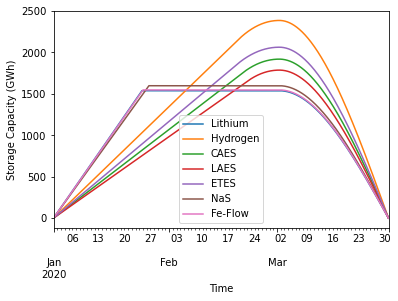

In [47]:
(storeSeriesData2/1e3).plot(ylabel='Storage Capacity (GWh)', xlabel='Time')

In [39]:
storageObjectivesdf

,Objective
Lithium,2.965263e+11
Hydrogen,2.809603e+10
CAES,1.034252e+10
LAES,1.706954e+11
ETES,1.845137e+11
NaS,9.962455e+11
Fe-Flow,1.982124e+11


<AxesSubplot:>

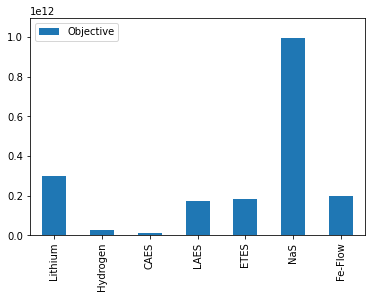

In [40]:
storageObjectivesdf.plot(kind="bar", 
    ylim=(storageObjectivesdf.values.min()*0,storageObjectivesdf.values.max()*1.1))

<AxesSubplot:>

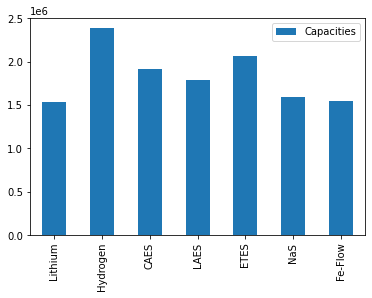

In [41]:
storageCapacitiesdf.plot(kind="bar")

In [42]:
# fig, (ax1, ax2) = plt.subplots(2,1)
# ax1.bar(storageObjectivesdf)